Import the packages including jax, equinox and diffrax

In [1]:
from typing import Union
import pdb
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import numpy as np
import control
import pdb
from jax.flatten_util import ravel_pytree
import jax
import lineax

from helpers_impl import  NeuralSDEKuramoto, get_gpu_memory, adj_lattice, criticalK, objective, order_param, objective_test
from tqdm import tqdm
from diffrax import diffeqsolve, Tsit5, ODETerm, ReversibleHeun, Heun
import gc
from IPython.display import clear_output
gc.collect()  
print(get_gpu_memory())
jax.config.update("jax_enable_x64", True)

[{'device': 0, 'total_memory': 24564.0, 'free_memory': 5110.625, 'used_memory': 19453.375}]


Initialize Kuramoto system: generate adjacency matrix and critical constant

In [3]:
#number of oscillators
data_size=16
#batch size
batch_size =1024
#scaling of frequencies: std= 1/scale
scale=5
#scaling of initial phases: std= 1/scale_kin
scale_kin=5


print(get_gpu_memory())
#generate adjacency matrix
A=adj_lattice(data_size, "erdos", 0.3)

#calculate critical constant and laplacian
Kcrit, L=criticalK(A,data_size,scale)
A=jnp.array(A)
L=jnp.array(L)

print(get_gpu_memory())

# Create an ensemble of models
print(Kcrit)
print(get_gpu_memory())

[{'device': 0, 'total_memory': 24564.0, 'free_memory': 5115.0, 'used_memory': 19449.0}]
[{'device': 0, 'total_memory': 24564.0, 'free_memory': 301.625, 'used_memory': 24262.375}]
221.4479173264424
[{'device': 0, 'total_memory': 24564.0, 'free_memory': 301.625, 'used_memory': 24262.375}]


 Initialize the Neural ODE and optimizer

In [15]:
#choose the force coefficient as 0.01 of critical constant
K=0.01*Kcrit

#initialize frequencies: global variables

freqs=np.random.randn(1,data_size)/scale
freqs=jnp.repeat(freqs, repeats=batch_size, axis=0)

#batched adjacency matrix and critical constant: global variables

K0 = jnp.repeat(K, repeats=batch_size, axis=0) 
A0= jnp.repeat(jnp.expand_dims(A, axis=0), repeats=batch_size, axis=0)

Functions for evaluation of system trajectories, control energy and loss

In [17]:
#common denominator term
@jax.jit
def smoothed_inverse_grad(grad, eps=1e-05):
    return 1.0 / jnp.sqrt(grad + eps)

#for cost and its gradient evaluation
@eqx.filter_value_and_grad  
def loss(model,y0):
  
    pred_y = jax.vmap(model)(tsss, y0, freqs, A0, K0)
    pred=jnp.squeeze(pred_y[0,-1,0:hidden_size])
  
    los_energy =jnp.mean( objective_test(pred_y[:,-1,0:hidden_size],A))

    return los_energy


@eqx.filter_jit
def predict(flat_params, static, unravel_fn):
    unflat_params = unravel_fn(flat_params)
    modelx = eqx.combine(static, unflat_params)
    
    pred_y = jax.vmap(modelx)(tsss, y0, freqs, A0, K0)
    pred=jnp.squeeze(pred_y[:,-1,0:hidden_size])

   

    return pred

#for energy and its gradient evaluation
@eqx.filter_jit 
def loss_kin(model,y0):
   
    pred_y = jax.vmap(model)(tsss,  y0, freqs, A0, K0)
    
    kin_energy=  jnp.mean(pred_y[:,-1,-1])
    orparam= jnp.mean(order_param(pred_y[:,-1,0:hidden_size],L))
    return kin_energy, orparam

  
@eqx.filter_jit
def make_step(model, batch_size, tsss, key, opt_state, y0,  counter, optim):

    key = jr.split(key, batch_size)
    
    #evaluate loss, energy and gradients
    value, grads = loss(model,y0)
    value1, orparam = loss_kin(model,y0)


    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    counter+=1
    return model, opt_state, grads, value, value1,  counter, orparam

In [ ]:
A loop over learning rates

In [19]:
#the lists to save the loss, control energy, order parameters for different learning rates
saved_global_loss=[]
saved_global_kin=[]
saved_global_emaloss=[]
saved_global_emakin=[]
saved_global_orparam=[]

t_size=32
t0 = 0
t1 = 1
ts = jnp.linspace(t0, t1, t_size)

for glob in tqdm(range(0,5)):
    seed=5679
    key = jr.PRNGKey(seed)
    strategy="vector"

    hidden_size=data_size
    width_size=8*data_size
    depth=5
    
    generator=NeuralSDEKuramoto(
            data_size,
            hidden_size,
            width_size,
            depth,
            strategy,
            key=key
        )
    
    tot_iter=150000

    learning_rate=0.00003*(2**glob)
    
    #adam optimizer
    b1=0.9
    b2=0.999
    eps=1e-08
    optim = optax.adam(learning_rate, b1=b1, b2=b2, eps=0, eps_root=eps)
    
    opt_state = optim.init(eqx.filter(generator, eqx.is_inexact_array))
    
    
    #save costs and energy
    saved_loss=[]
    saved_kin=[]
    #save directional derivatives
    saved_product1=[]
    saved_product2=[]
    saved_ema_loss=[]
    saved_ema_kin=[]
    saved_orparam=[]
    ini_key=jr.PRNGKey(seed)
    key= jr.split(key, 1)[0]
    alpha=0.995
    
    counter=jnp.int32(0)

    
    tss = jnp.expand_dims(ts, axis=0)
    tsss = jnp.repeat(tss, repeats=batch_size, axis=0)

    
    score=10000000
    epochs=[]
    ema_loss=0
    ema_kin=0
    for k in tqdm(range(0,tot_iter)):
       
        key= jr.split(key, 1)[0]
       
        y0 = jr.normal(key, shape=(batch_size, data_size)) / scale_kin   
        y00=jnp.concatenate([y0,jnp.zeros((batch_size,1))], axis=1)
        #run optimization steps, evaluate the cost and energy, directional derivatives
        generator, opt_state, grads, losses, kin,  counter, orparam= make_step(generator, batch_size, tsss, key, opt_state, y0, counter, optim)
        
        if k==0:
            ema_loss=losses
            ema_kin = kin
        else:
            ema_loss=ema_loss*alpha+losses*(1-alpha)
            ema_kin=ema_kin*alpha+kin*(1-alpha)
            
        if ema_loss<score:
            score=ema_loss
    
        print("ema loss")
        print(ema_loss)
        print("kin")
        print(kin)
        print("order param")
        print(orparam)
        saved_loss.append(jax.device_get(losses))
        saved_kin.append(jax.device_get(kin))
        saved_ema_loss.append(jax.device_get(ema_loss))
        saved_ema_kin.append(jax.device_get(ema_kin))
        saved_orparam.append(jax.device_get(orparam))
    
        if k%500==0:
            gc.collect()
            clear_output(wait=True)
            
        if jnp.linalg.norm(ema_loss)<1e-06:
            break
        del grads, losses, kin
        
    saved_global_loss.append(saved_loss)
    saved_global_kin.append(saved_kin)
    saved_global_emaloss.append(saved_ema_loss)
    saved_global_emakin.append(saved_ema_kin)
    saved_global_orparam.append(saved_orparam)


  0%|          | 3/150000 [00:03<31:32:21,  1.32it/s]

ema loss
4.638024679393853
kin
0.0035350479125295458
order param
0.9793616163576027
ema loss
4.6383683122414565
kin
0.0035314432387526106
order param
0.9791544925805789



  0%|          | 5/150000 [00:03<16:08:06,  2.58it/s]

ema loss
4.6380652273387835
kin
0.0035280420423953063
order param
0.9797984940221691
ema loss
4.637821867648353
kin
0.0035247968043883647
order param
0.9796748734586115



  0%|          | 7/150000 [00:03<10:43:37,  3.88it/s]

ema loss
4.637477281628381
kin
0.0035216492863804853
order param
0.9797912404723408
ema loss
4.637078599999159
kin
0.0035185151115415046
order param
0.9798846157785972



  0%|          | 9/150000 [00:04<8:37:12,  4.83it/s]

ema loss
4.636964644898874
kin
0.003515748628216291
order param
0.9795824199357872
ema loss
4.6371502795738335
kin
0.0035132604482002046
order param
0.9793064828942306



  0%|          | 11/150000 [00:04<7:30:54,  5.54it/s]

ema loss
4.637227647511804
kin
0.0035109432943096976
order param
0.9793832857531455
ema loss
4.637333508310836
kin
0.0035088934090410587
order param
0.9793425421206345



  0%|          | 13/150000 [00:04<6:56:33,  6.00it/s]

ema loss
4.63721119724294
kin
0.0035070737670867772
order param
0.9795731317244671
ema loss
4.637487219412477
kin
0.0035055492796479833
order param
0.9791592465644913



  0%|          | 15/150000 [00:05<6:39:47,  6.25it/s]

ema loss
4.637476709190404
kin
0.0035041906484366008
order param
0.9794940284454317
ema loss
4.637190880683861
kin
0.003503142191716693
order param
0.9797498792683761



  0%|          | 17/150000 [00:05<6:29:46,  6.41it/s]

ema loss
4.636619880082049
kin
0.0035026473423051536
order param
0.9800386839199063
ema loss
4.6364991661362716
kin
0.003502185950140726
order param
0.9795994017302179



  0%|          | 19/150000 [00:05<6:27:40,  6.45it/s]

ema loss
4.636094848887633
kin
0.003501836965400505
order param
0.9798828679188203
ema loss
4.635937669827194
kin
0.0035018304772683195
order param
0.9796151270110233


  0%|          | 0/5 [00:05<?, ?it/s]

KeyboardInterrupt



In [143]:
%store saved_global_emaloss
%store saved_global_emakin
%store saved_global_orparam

Stored 'saved_global_emaloss' (list)
Stored 'saved_global_emakin' (list)
Stored 'saved_global_orparam' (list)


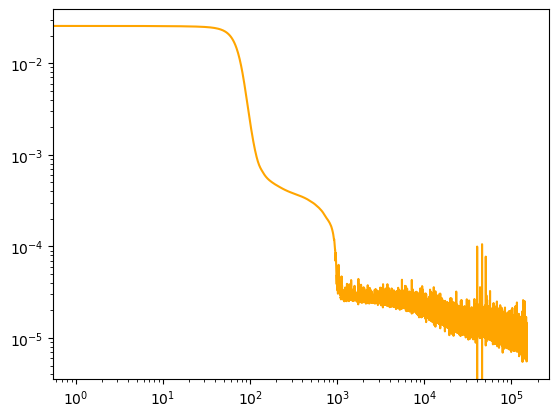

In [73]:
plt.plot(1-smoothed_loss1, label="$h=2^{-15}$",c='orange')
plt.yscale('log')
plt.xscale('log')

In [81]:
from scipy.signal import savgol_filter 
smoothed_loss1 = savgol_filter(np.array(saved_global_orparam[0]), window_length=51, polyorder=2)
smoothed_loss2 = savgol_filter(np.array(saved_global_orparam[1]), window_length=51, polyorder=2)
smoothed_loss3 = savgol_filter(np.array(saved_global_orparam[2]), window_length=51, polyorder=2)
smoothed_loss4 = savgol_filter(np.array(saved_global_orparam[3]), window_length=51, polyorder=2)

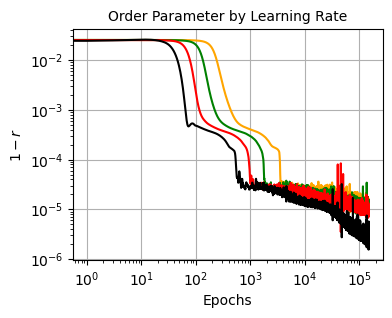

In [139]:
plt.figure(figsize=(4, 3))
plt.plot(1-smoothed_loss1, label="$h=2^{-15}$",c='orange')
plt.plot(1-smoothed_loss2, label="$h=2^{-14}$", c='green')
plt.plot(1-smoothed_loss3, label="$h=2^{-13}$", c='red')
plt.plot(1-smoothed_loss4, label="$h=2^{-12}$", c='black')

#plt.plot(saved_global_loss[4])
plt.ylabel('$1-r$', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Order Parameter by Learning Rate", fontsize=10)
plt.legend
plt.grid(True)
plt.savefig("orderparam_learning.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

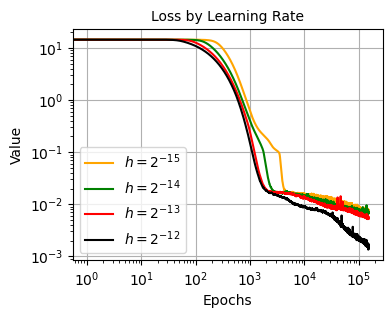

In [131]:
plt.figure(figsize=(4, 3))
plt.plot(saved_global_emaloss[0], label="$h=2^{-15}$",c='orange')
plt.plot(saved_global_emaloss[1], label="$h=2^{-14}$", c='green')
plt.plot(saved_global_emaloss[2], label="$h=2^{-13}$", c='red')
plt.plot(saved_global_emaloss[3], label="$h=2^{-12}$", c='black')

#plt.plot(saved_global_loss[4])
plt.ylabel('Value', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.title("Loss by Learning Rate", fontsize=10)
plt.grid(True)
plt.savefig("kuramoto_finalcost.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

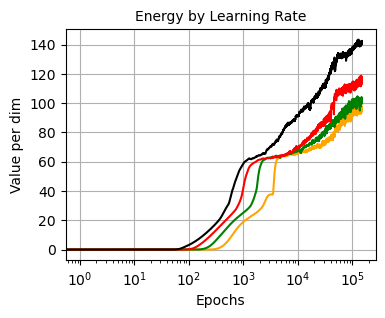

In [141]:
plt.figure(figsize=(4, 3))
plt.plot(np.array(saved_global_emakin[0])/25, label="$h=2^{-15}$",c='orange')
plt.plot(np.array(saved_global_emakin[1])/25,label="$h=2^{-14}$", c='green')
plt.plot(np.array(saved_global_emakin[2])/25,label="$h=2^{-13}$", c='red')
plt.plot(np.array(saved_global_emakin[3])/25, label="$h=2^{-12}$", c='black')
plt.ylabel('Value per dim', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.xscale('log')
plt.title("Energy by Learning Rate", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend
plt.grid(True)
plt.savefig("kuramoto_energy.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()